In [17]:
import lenstronomy
print(lenstronomy.__version__)

1.12.5


In [1]:
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
import lenstronomy.Util.util as util
from astropy.cosmology import FlatLambdaCDM

from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import Planck15 as cosmo

In [2]:
# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
cosmo=cosmo

/var/folders/sl/ck56tyxs0fxf0m9pr2t9jjbc0000gn/T/ipykernel_1670/2960048818.py:15: RuntimeWarning: divide by zero encountered in log10
  plt.matshow(np.log10(kernel))


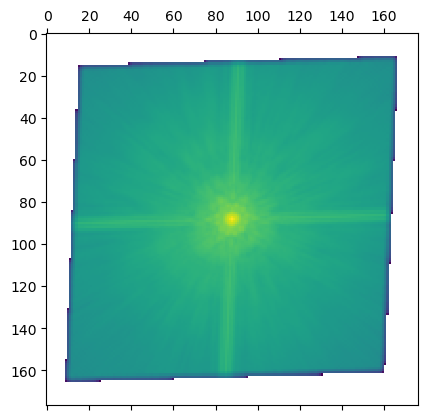

In [3]:
#############################################
### PSF section
#############################################

# The parameter choice for HST PSF: instrument-ACS, Detector-WFC2(optics), Filter-F814W, array size-147, PSF center (x,y)-(2000,1000)


# import PSF file
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, '212/tinypsf00.fits') #
kernel = pyfits.getdata(psf_filename)

plt.matshow(np.log10(kernel))
plt.show()

In [101]:
# data specifics
background_rms = 0.2  #  background noise per pixel (Gaussian rms value)
exp_time = 80.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 80  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91  # PSF kernel size (odd number required).


# initial input simulation
# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
# generate the psf variables
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
psf_class = PSF(**kwargs_psf)

In [103]:
print(cosmo)

FlatLambdaCDM(name="Planck15", H0=67.74 km / (Mpc s), Om0=0.3075, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)


In [144]:
####################
## Input mass and concentration
####################

Mpert = 10**11   #the mass of the subhalo
Cpert = 100  #the concentration of the halo

lens_cosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo) #cosmo=FlatLambdaCDM(name="Planck15", H0=67.74 km / (Mpc s), Om0=0.3075, Tcmb0=2.725 K, Neff=3.046, m_nu=[0.  , 0.  , 0.06] eV, Ob0=0.0486)

Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=Mpert, c=Cpert)

print("Rs: ", Rs_angle, "angle: ", alpha_Rs)

Rs:  0.12954279662519458 angle:  0.2321325456990353


/var/folders/sl/ck56tyxs0fxf0m9pr2t9jjbc0000gn/T/ipykernel_1670/621890817.py:62: RuntimeWarning:

invalid value encountered in log10



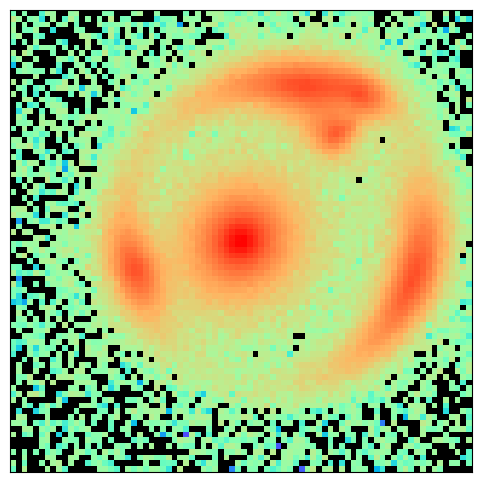

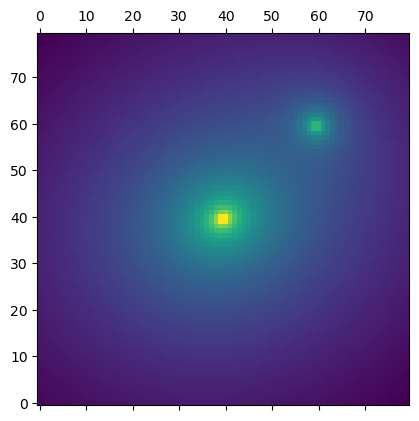

In [107]:
#############################
# lensing quantities ####################### The parameter we are changing

# lensing quantities
kwargs_sie = {'theta_E': 1.2, 'e1': 0.05, 'e2': 0.05, 'center_x': 0, 'center_y': 0}
kwargs_nfw = {'alpha_Rs': alpha_Rs, 'Rs': Rs_angle, 'center_x': 1, 'center_y': 1}
# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['SIE', 'NFW']
kwargs_lens = [kwargs_sie, kwargs_nfw]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# choice of source type
source_x = 0.3
source_y = 0.1


# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8  # Position angle (radians) and axis ratio (q = b/a)
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
#n=1, exponential profile, for spiral galaxy
#kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)

# lens light model
phi_G, q = 0.9, 0.9
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)


kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False} 

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)# update kwargs_data with the newly generated mock
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)


# display the initial simulated image
cmap_string = 'rainbow'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4 #max and min of color scales: pixels at log_10 (v), where -4 is 10^-4
v_max = 2 #2 is 100

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

# and here we compute the convergence at each pixel position
x_coords, y_coords = data_class.pixel_coordinates
kappa = lens_model_class.kappa(util.image2array(x_coords), util.image2array(y_coords), kwargs_lens)
plt.matshow(util.array2image(np.log10(kappa)), origin='lower')
plt.show()

In [109]:
#######################################
### Recovering the input parameters WITHOUT the clump
#######################################

# First we only model the macro-model
lens_model_simple_list = ['SIE']

# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append({'theta_E': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
#kwargs_lens_init.append(kwargs_pemd)
kwargs_lens_sigma.append({'theta_E': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append(kwargs_sersic_lens)
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append(kwargs_sersic_source)
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_model = {'lens_model_list': lens_model_simple_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 }

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}



# numerical options and fitting sequences

num_source_model = len(source_model_list)

kwargs_constraints = {}

kwargs_likelihood = {'check_bounds': True,
                     'source_marg': False,}

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}
kwargs_init = [kwargs_lens, kwargs_source, kwargs_lens_light, []]


mpi = False  # MPI possible, but not supported through that notebook.

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=mpi)

fitting_kwargs_list = [['PSO', {'sigma_scale': .1, 'n_particles': 100, 'n_iterations': 100}]]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...


100%|█████████████████████████████████████████| 100/100 [00:18<00:00,  5.53it/s]

Max iteration reached! Stopping.
-29.149111298646762 reduced X^2 of best position
-93000.2395983325 log likelihood
6381 effective number of data points
[{'theta_E': 1.3023798686513957, 'e1': 0.1475839920560251, 'e2': 0.05822505562299508, 'center_x': 0.1249563279359061, 'center_y': -0.015540011831945338}] lens result
[{'amp': 1, 'R_sersic': 0.12009868820861976, 'n_sersic': 1.8316723284945196, 'e1': 0.0092227123310968, 'e2': 0.3792197003148076, 'center_x': 0.3078743534384922, 'center_y': 0.08939326768327392}] source result
[{'amp': 1, 'R_sersic': 0.21702181750159308, 'n_sersic': 2.4174665060929525, 'e1': -0.03164595421937098, 'e2': 0.06192307988888557, 'center_x': 0.00019207292558529173, 'center_y': 0.0011726786720982502}] lens light result
[] point source result
[] tracer source result
{} special param result
18.069226026535034 time used for  PSO
18.078524112701416 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


/Users/kunyangliu/.local/lib/python3.11/site-packages/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning:

invalid value encountered in log10



-29.062574874478905 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  29.062574874478898


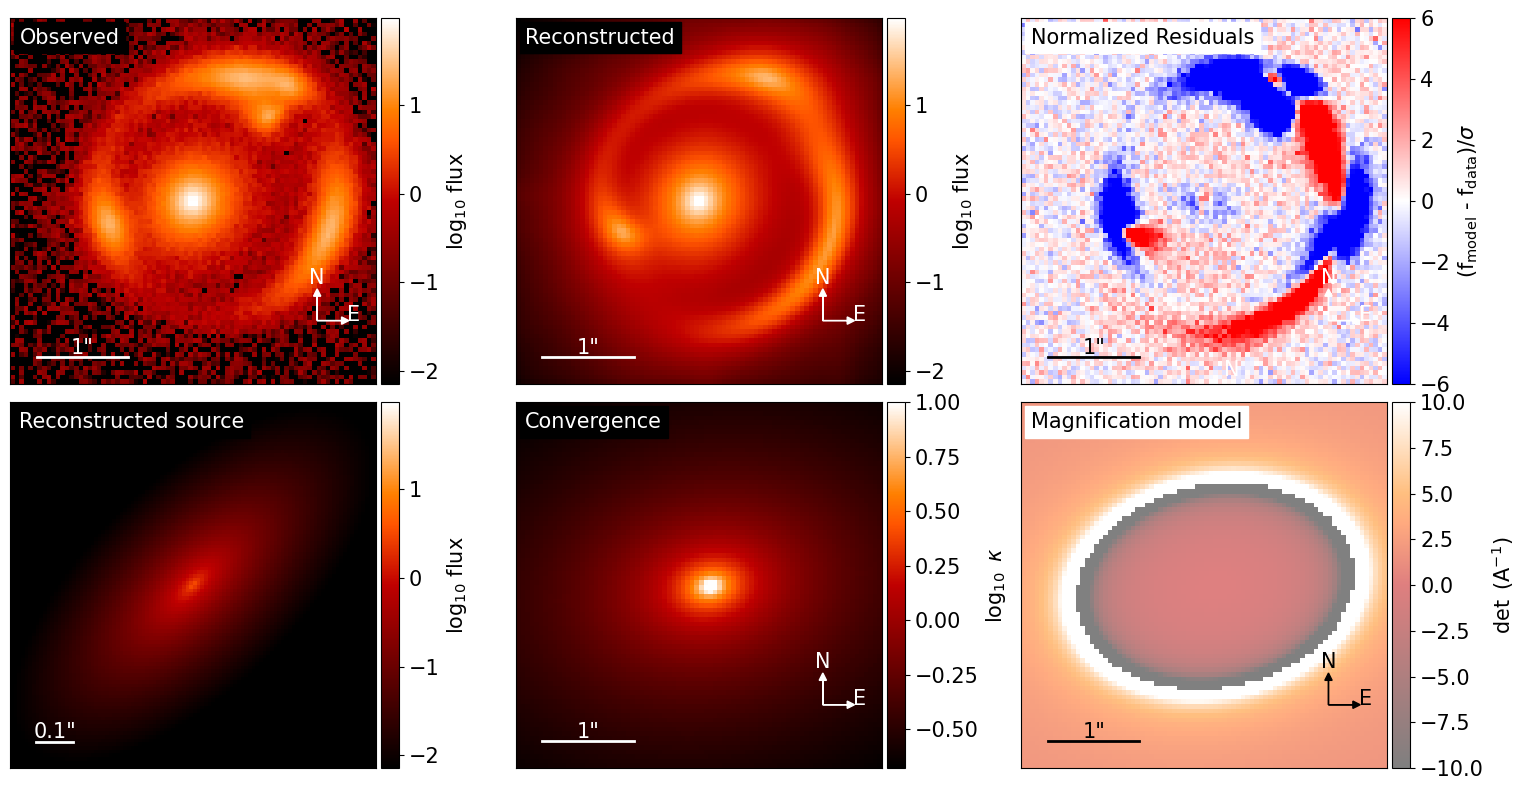

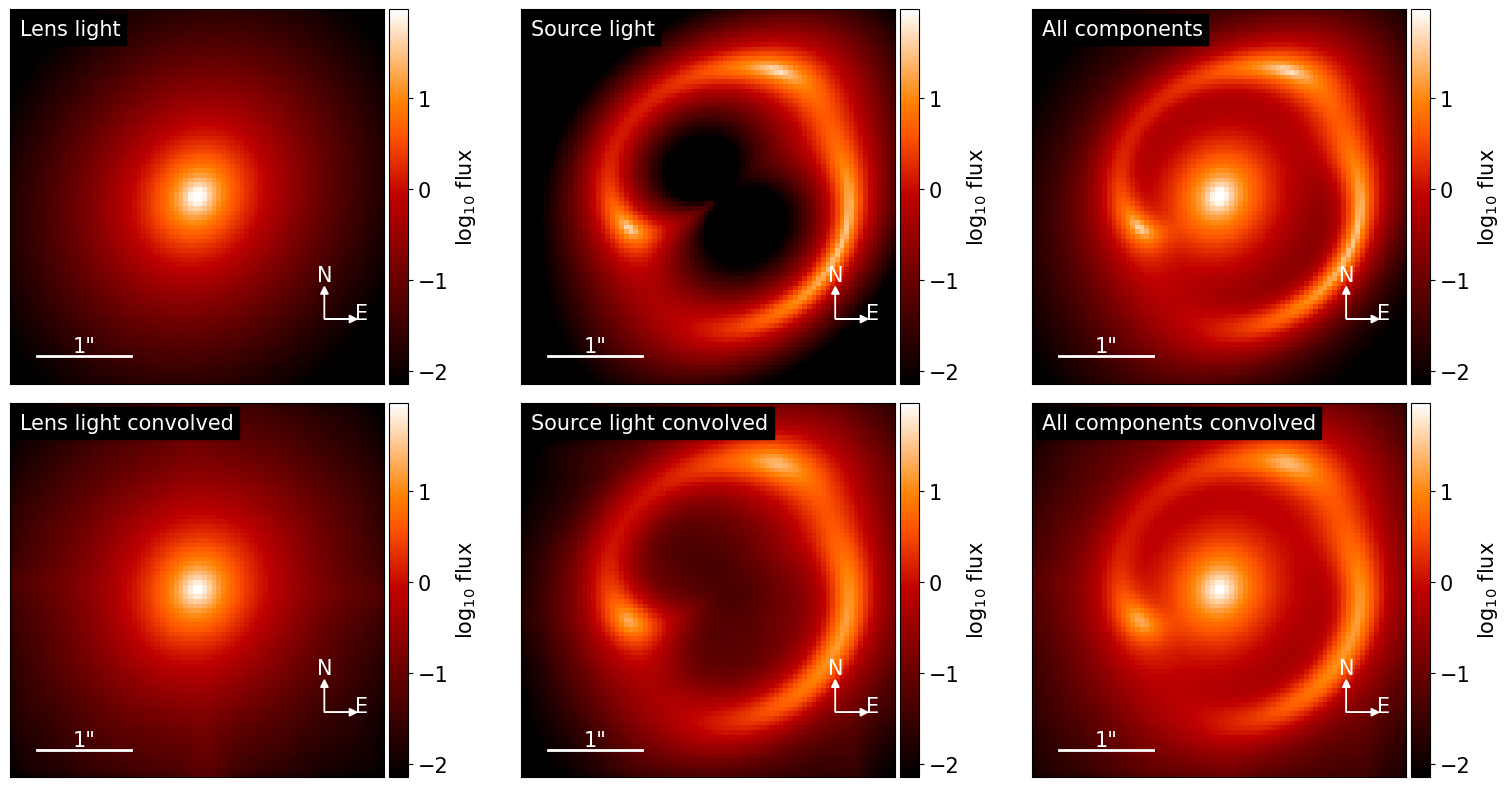

{'kwargs_lens': [{'theta_E': 1.3023798686513957, 'e1': 0.1475839920560251, 'e2': 0.05822505562299508, 'center_x': 0.1249563279359061, 'center_y': -0.015540011831945338}], 'kwargs_source': [{'amp': 1965.7199230675953, 'R_sersic': 0.12009868820861976, 'n_sersic': 1.8316723284945196, 'e1': 0.0092227123310968, 'e2': 0.3792197003148076, 'center_x': 0.3078743534384922, 'center_y': 0.08939326768327392}], 'kwargs_lens_light': [{'amp': 6570.083306327242, 'R_sersic': 0.21702181750159308, 'n_sersic': 2.4174665060929525, 'e1': -0.03164595421937098, 'e2': 0.06192307988888557, 'center_x': 0.00019207292558529173, 'center_y': 0.0011726786720982502}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': [], 'kwargs_tracer_source': []}


/Users/kunyangliu/.local/lib/python3.11/site-packages/lenstronomy/Plots/model_band_plot.py:1168: RuntimeWarning:

invalid value encountered in log10



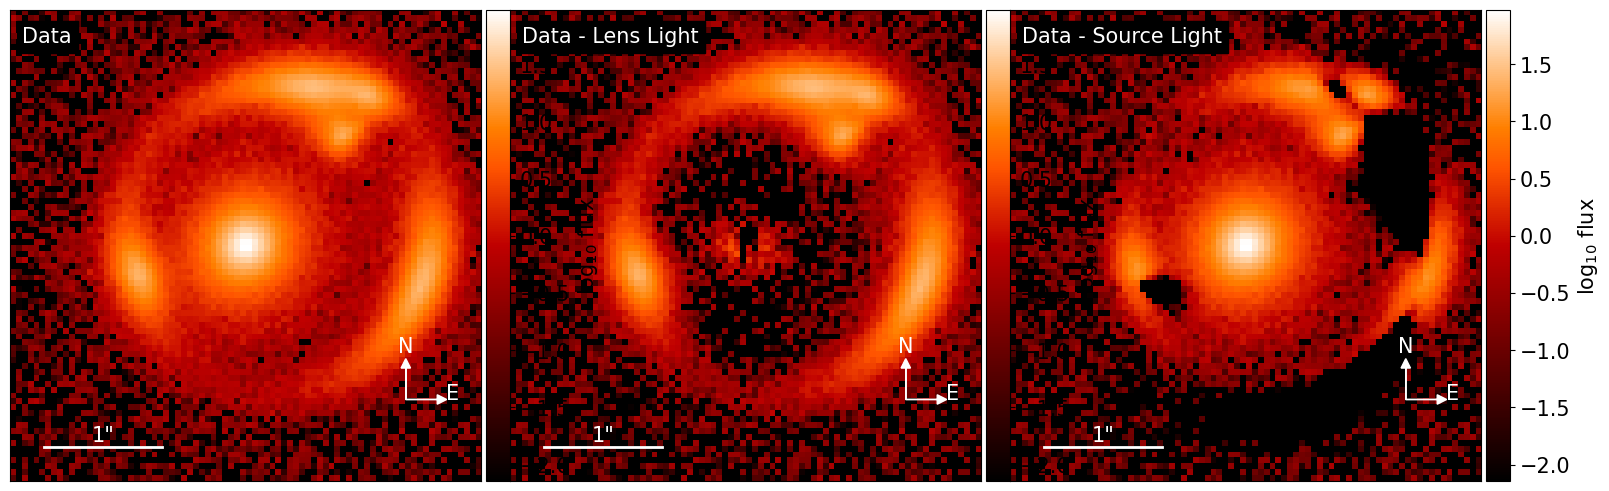

In [110]:
###########################
### analyse model output
###########################

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)
    
f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.subtract_from_data_plot(ax=axes[0], text='Data')
modelPlot.subtract_from_data_plot(ax=axes[1], text='Data - Lens Light', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2], text='Data - Source Light', source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

In [111]:
##Before recovering the parameter with the clump

#we need to calculate the limit of R_s and alpha_Rs
M_bounds = [1e5, 1e12]
c_bounds = [1., 30]

Rs_angle_low, alpha_Rs_low = lens_cosmo.nfw_physical2angle(M_bounds[0], c_bounds[0])

Rs_angle_up, alpha_Rs_up = lens_cosmo.nfw_physical2angle(M_bounds[1], c_bounds[1])

print("lower limit: ", Rs_angle_low, alpha_Rs_low)
print("upper limit: ", Rs_angle_up, alpha_Rs_up)

##This attempt is wrong

lower limit:  0.1295427966251946 4.356705949215936e-06
upper limit:  0.9303049829768815 0.475114492443561


In [112]:
##Before recovering the parameter with the clump

#we need to calculate the limit of R_s and alpha_Rs
M_mean = 1e8
c_mean = 15

Rs_angle_mean, alpha_Rs_mean = lens_cosmo.nfw_physical2angle(M_mean, c_mean)

print(Rs_angle_mean, alpha_Rs_mean)

M_upp = 1e11
c_upp = 100

Rs_angle_upp, alpha_Rs_upp = lens_cosmo.nfw_physical2angle(M_upp, c_upp)

print(Rs_angle_upp, alpha_Rs_upp)

M_upp = 1e11
c_upp = 50

Rs_angle_upp, alpha_Rs_upp = lens_cosmo.nfw_physical2angle(M_upp, c_upp)

print(Rs_angle_upp, alpha_Rs_upp)

##looks like it's not fully working, so we want to see whether we can find some relation by 

0.0863618644167964 0.0006878295259692456
0.12954279662519458 0.2321325456990353
0.25908559325038916 0.14255538495140094


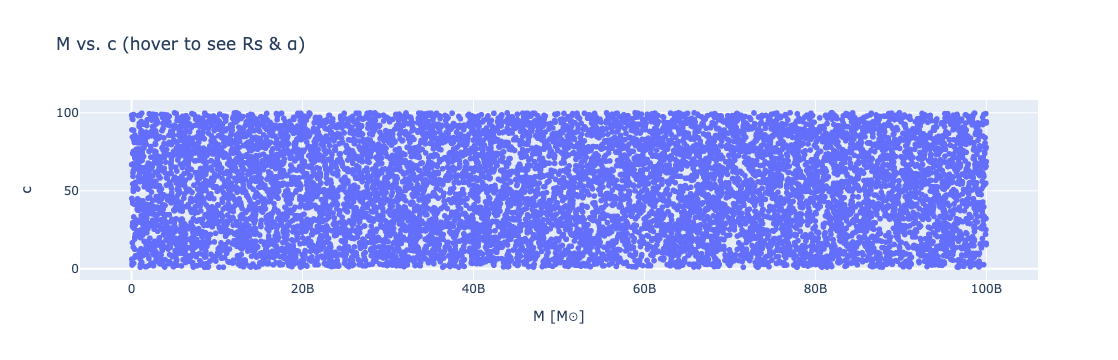

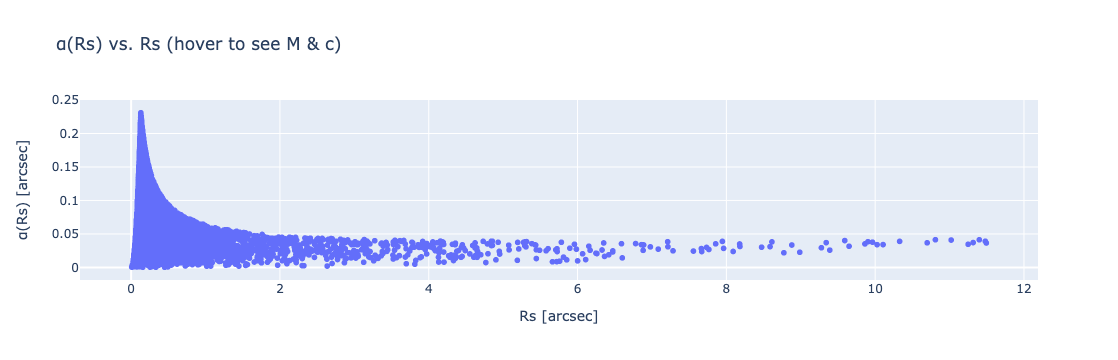

In [113]:
#####################################
### sampling the mass-c relations
######################################
import pandas as pd
import plotly.express as px

# Number of random samples
N = 10000

M = np.random.uniform(1e5, 1e11, N)
c = np.random.uniform(1, 100, N)
Rs = np.empty(N); alpha = np.empty(N)
for i in range(N):
    Rs[i], alpha[i] = lens_cosmo.nfw_physical2angle(M[i], c[i])

# 2) Build a DataFrame
df = pd.DataFrame({
    'index': np.arange(N),
    'M': M,
    'c': c,
    'Rs': Rs,
    'alpha': alpha
})

# 3) Mass vs. Concentration
fig1 = px.scatter(df, x='M', y='c',
                  hover_data=['index','Rs','alpha'],
                  title='M vs. c (hover to see Rs & α)')
fig1.update_layout(xaxis_title='M [M⊙]',
                   yaxis_title='c')
fig1.show()

# 4) Rs vs. α(Rs)
fig2 = px.scatter(df, x='Rs', y='alpha',
                  hover_data=['index','M','c'],
                  title='α(Rs) vs. Rs (hover to see M & c)')
fig2.update_layout(xaxis_title='Rs [arcsec]',
                   yaxis_title='α(Rs) [arcsec]')
fig2.show()

mean Rs 0.45790802260221336 mean a 0.08386472681016002
range of Rs:  -2.2713745492630215 3.187190594467448
range of alpha_Rs:  -0.07289989349210993 0.24062934711242998


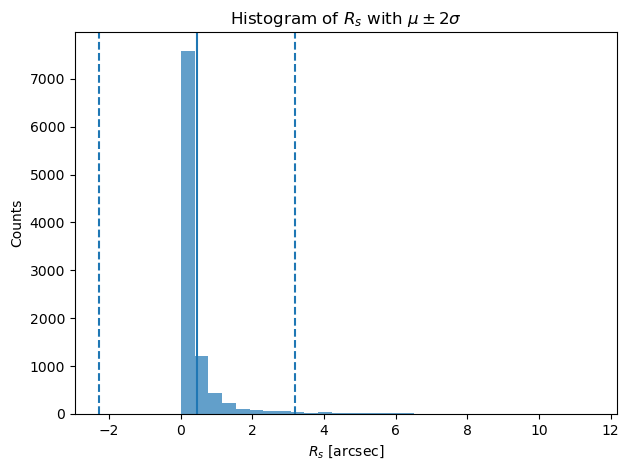

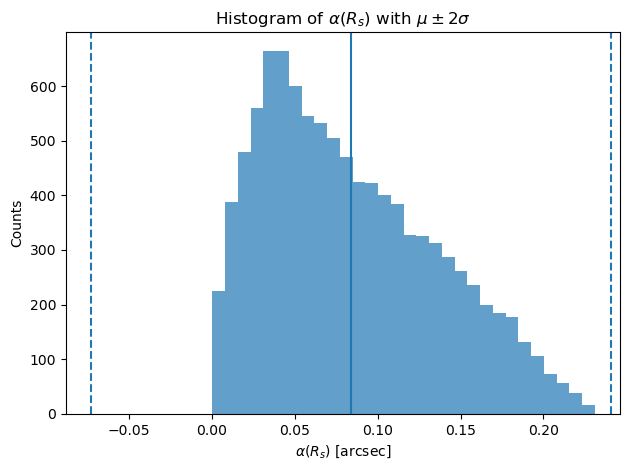

In [114]:
# --- compute mean and σ ---
mu_Rs    = np.mean(Rs)
sigma_Rs = np.std(Rs)
lower_Rs, upper_Rs = mu_Rs - 3*sigma_Rs, mu_Rs + 3*sigma_Rs

mu_a     = np.mean(alpha)
sigma_a  = np.std(alpha)
lower_a, upper_a = mu_a - 3*sigma_a, mu_a + 3*sigma_a

print("mean Rs", mu_Rs, "mean a", mu_a)
print("range of Rs: ", lower_Rs, upper_Rs)
print("range of alpha_Rs: ", lower_a, upper_a)
# --- plot Rs distribution ---
plt.figure()
plt.hist(Rs, bins=30, alpha=0.7)
plt.axvline(mu_Rs, linestyle='solid')
plt.axvline(lower_Rs, linestyle='dashed')
plt.axvline(upper_Rs, linestyle='dashed')
plt.xlabel('$R_s$ [arcsec]')
plt.ylabel('Counts')
plt.title('Histogram of $R_s$ with $\mu\\pm2\\sigma$')
plt.tight_layout()

# --- plot alpha distribution ---
plt.figure()
plt.hist(alpha, bins=30, alpha=0.7)
plt.axvline(mu_a, linestyle='solid')
plt.axvline(lower_a, linestyle='dashed')
plt.axvline(upper_a, linestyle='dashed')
plt.xlabel('$\\alpha(R_s)$ [arcsec]')
plt.ylabel('Counts')
plt.title('Histogram of $\\alpha(R_s)$ with $\\mu\\pm2\\sigma$')
plt.tight_layout()

plt.show()

In [115]:
#######################################
### Recovering the input parameters WITH the clump
#######################################

lens_model_substructure_list = ['SIE', 'NFW']

# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append({'theta_E': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
#kwargs_lens_init.append(kwargs_pemd)
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10})


fixed_lens.append({})
kwargs_lens_init.append({'alpha_Rs': 0.2, 'Rs': 0.1, 'center_x': 1, 'center_y': 1})
#kwargs_lens_init.append(kwargs_nfw)
kwargs_lens_sigma.append({'alpha_Rs': 0.05, 'Rs': 0.05, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'alpha_Rs': 0., 'Rs': 0.0001, 'center_x': -2, 'center_y': -2})
kwargs_upper_lens.append({'alpha_Rs': upper_a, 'Rs': upper_Rs, 'center_x': 2, 'center_y': 2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
#kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_lens_light_init.append(kwargs_result['kwargs_lens_light'][0])
kwargs_lens_light_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
#kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_source_init.append(kwargs_result['kwargs_source'][0])
kwargs_source_sigma.append({'n_sersic': 0.01, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_model = {'lens_model_list': lens_model_substructure_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 }

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 800, 'n_iterations': 100}]]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...


100%|█████████████████████████████████████████| 100/100 [02:30<00:00,  1.51s/it]

Max iteration reached! Stopping.
-1.0201419877624933 reduced X^2 of best position
-3252.7227279807103 log likelihood
6377 effective number of data points
[{'theta_E': 1.1992757643822292, 'e1': 0.05035531337127231, 'e2': 0.0495961585356803, 'center_x': -0.0007377067601261758, 'center_y': -0.001189988501710118}, {'Rs': 0.13052768131561154, 'alpha_Rs': 0.23232857822148104, 'center_x': 0.9971281842582855, 'center_y': 0.9988665964217196}] lens result
[{'amp': 1, 'R_sersic': 0.10011794250786211, 'n_sersic': 1.00660010108633, 'e1': 0.05802289943102265, 'e2': 0.09267377153338957, 'center_x': 0.2997477217482977, 'center_y': 0.09923314995552443}] source result
[{'amp': 1, 'R_sersic': 0.20070978959750985, 'n_sersic': 2.045253713460338, 'e1': -0.03964296075532961, 'e2': 0.05712517193579951, 'center_x': -0.0001914698663813375, 'center_y': -0.000936701849804522}] lens light result
[] point source result
[] tracer source result
{} special param result
150.85563206672668 time used for  PSO
150.8822309

In [142]:
 _, _, c, _, M = lens_cosmo.nfw_angle2physical(Rs_angle= 0.13052768131561154,alpha_Rs=0.23232857822148104) #input: Rs and alpha

M, c

(2.1459877058971796e+18, array(27579.50000286))

-0.9968727986787982 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  0.9968727986787982


/Users/kunyangliu/.local/lib/python3.11/site-packages/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning:

invalid value encountered in log10



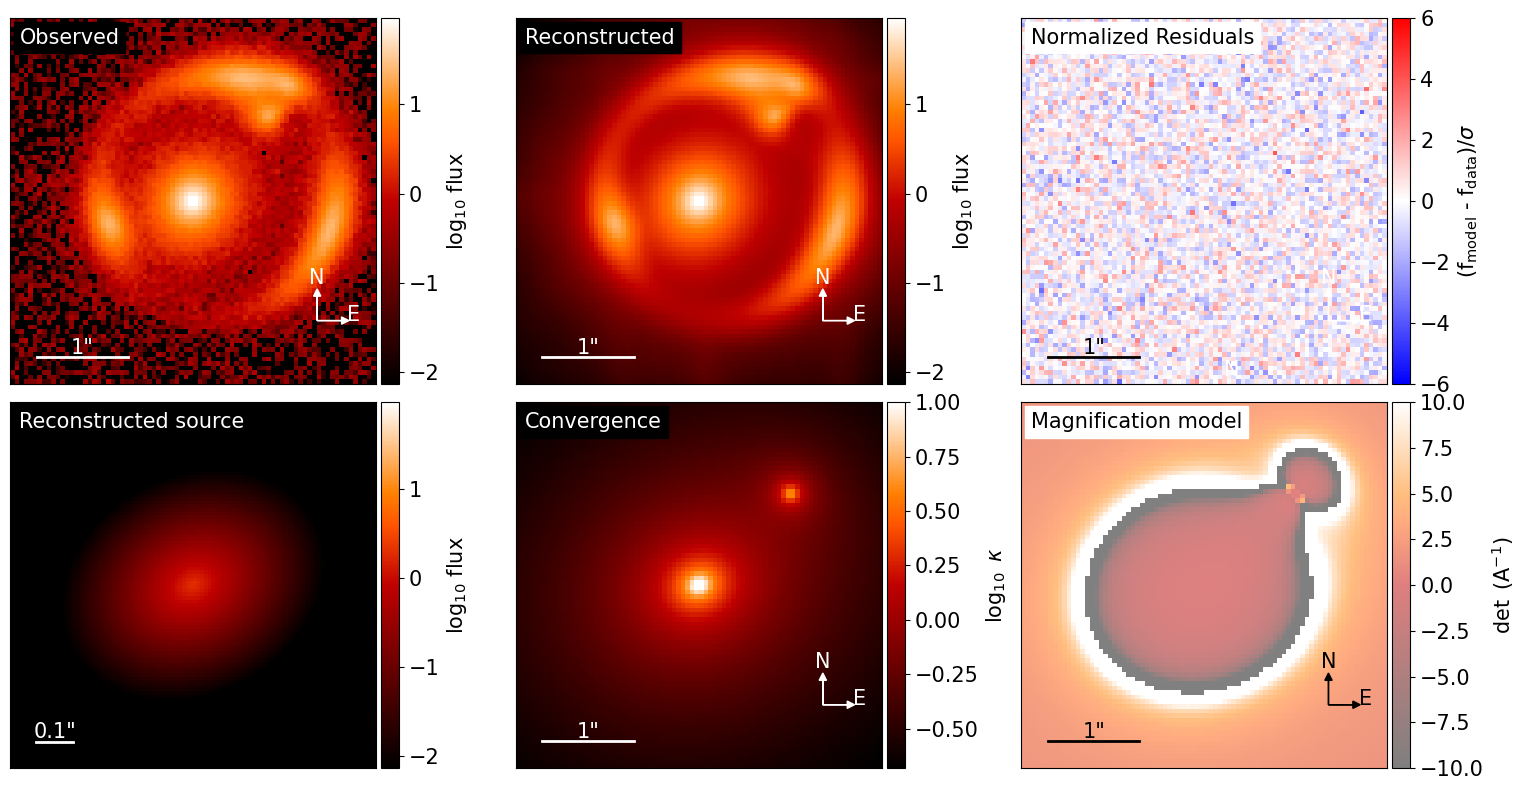

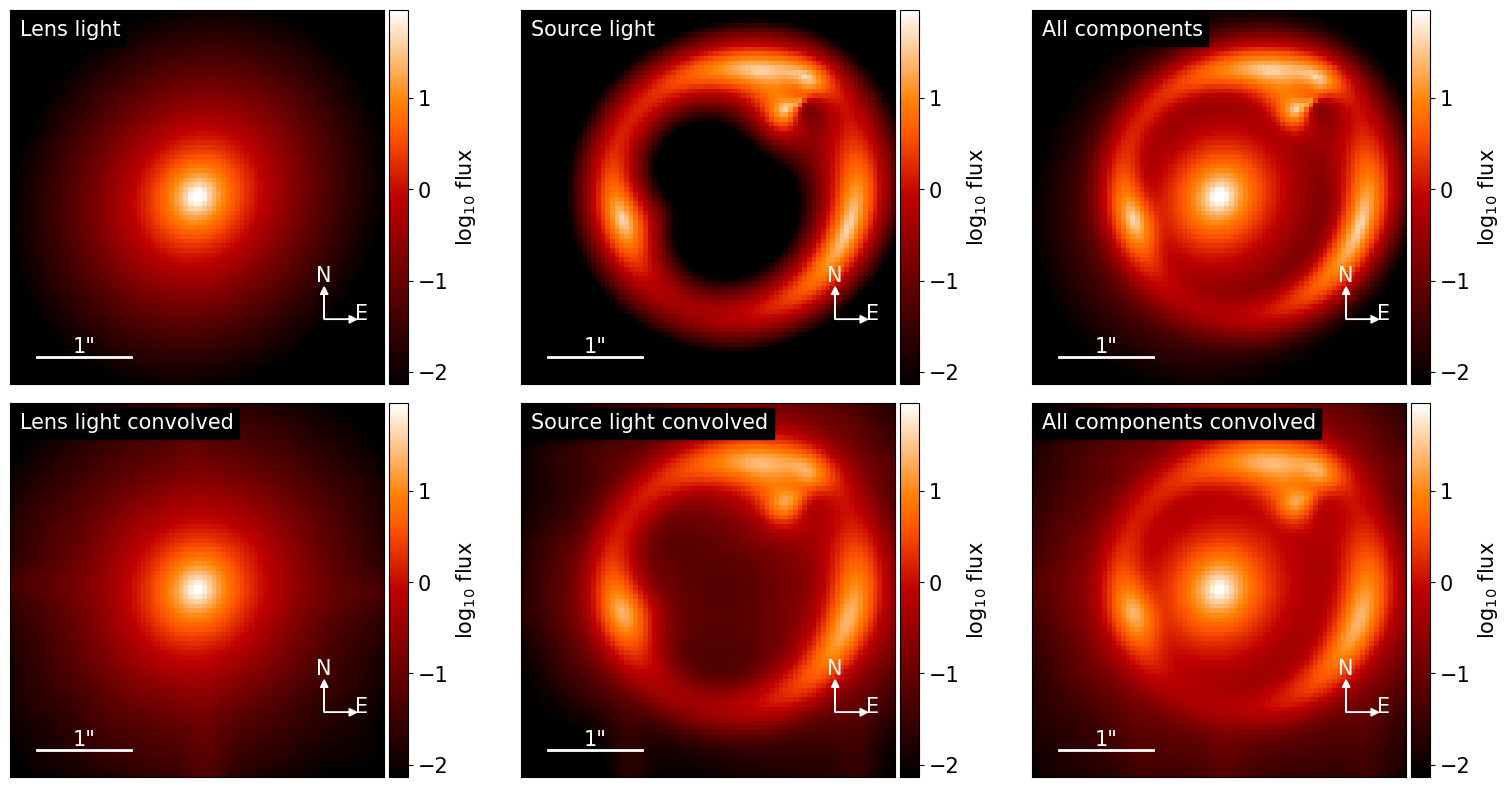

{'kwargs_lens': [{'theta_E': 1.2002894732864264, 'e1': 0.05046682185109631, 'e2': 0.049595035329207296, 'center_x': -0.001226023563470349, 'center_y': -0.0004767196794750959}, {'Rs': 0.12905326743795373, 'alpha_Rs': 0.23306842250714502, 'center_x': 1.0006199764452217, 'center_y': 0.9998905470050689}], 'kwargs_source': [{'amp': 4034.1723859954495, 'R_sersic': 0.09990998729042447, 'n_sersic': 0.9642833402260537, 'e1': 0.06372742670015384, 'e2': 0.09237504437206116, 'center_x': 0.30010681807234174, 'center_y': 0.09963991869568306}], 'kwargs_lens_light': [{'amp': 7826.397264652792, 'R_sersic': 0.20082113289301937, 'n_sersic': 2.076784126576562, 'e1': -0.016588869246051057, 'e2': 0.0527123816027745, 'center_x': -0.00041549310681919906, 'center_y': -0.0006998009771215202}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': [], 'kwargs_tracer_source': []}


/Users/kunyangliu/.local/lib/python3.11/site-packages/lenstronomy/Plots/model_band_plot.py:1168: RuntimeWarning:

invalid value encountered in log10



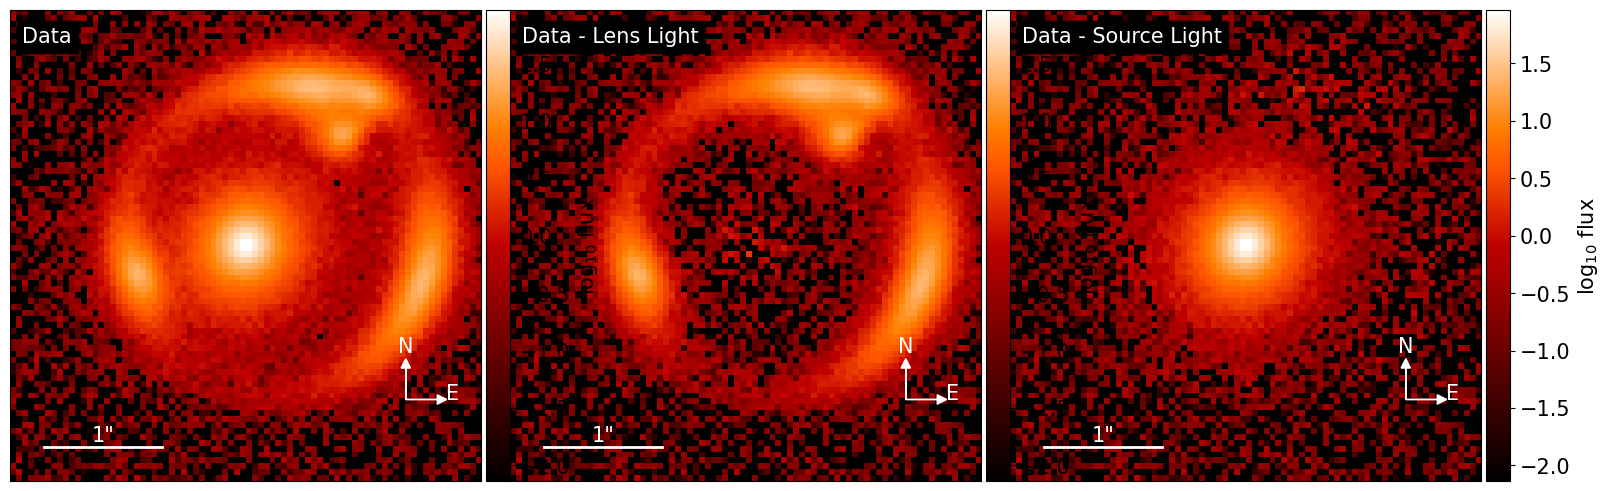

In [75]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)
    
f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.subtract_from_data_plot(ax=axes[0], text='Data')
modelPlot.subtract_from_data_plot(ax=axes[1], text='Data - Lens Light', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2], text='Data - Source Light', source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

In [128]:
#######################################
### MCMC
#######################################

# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append({'theta_E': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0})
#kwargs_lens_init.append(kwargs_sie)
#kwargs_lens_init.append(kwargs_result['kwargs_lens'][0])
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10})


fixed_lens.append({})
kwargs_lens_init.append(kwargs_result['kwargs_lens'][1])
#kwargs_lens_init.append(kwargs_nfw)
kwargs_lens_sigma.append({'alpha_Rs': 0.05, 'Rs': 0.05, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'alpha_Rs': 0., 'Rs': 0.0001, 'center_x': -2, 'center_y': -2})
kwargs_upper_lens.append({'alpha_Rs': upper_a, 'Rs': upper_Rs, 'center_x': 2, 'center_y': 2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
#kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_lens_light_init.append(kwargs_result['kwargs_lens_light'][0])
kwargs_lens_light_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
#kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_source_init.append(kwargs_result['kwargs_source'][0])
kwargs_source_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_model = {'lens_model_list': lens_model_substructure_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 }

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['MCMC', {'n_burn': 900, 'n_run': 900, 'walkerRatio': 8, 'sigma_scale': 0.2}]]
start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')


MCMC selected. Sampling with default option emcee.


100%|███████████████████████████████████████| 1800/1800 [09:45<00:00,  3.07it/s]

Computing the MCMC...
Number of walkers =  168
Burn-in iterations:  900
Sampling iterations (in current run): 1800
585.8670651912689 time taken for MCMC sampling
585.8876941204071 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


number of non-linear parameters in the MCMC process:  21
parameters in order:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'Rs_lens1', 'alpha_Rs_lens1', 'center_x_lens1', 'center_y_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
number of evaluations in the MCMC process:  151200


/var/folders/sl/ck56tyxs0fxf0m9pr2t9jjbc0000gn/T/ipykernel_1670/2176487861.py:38: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



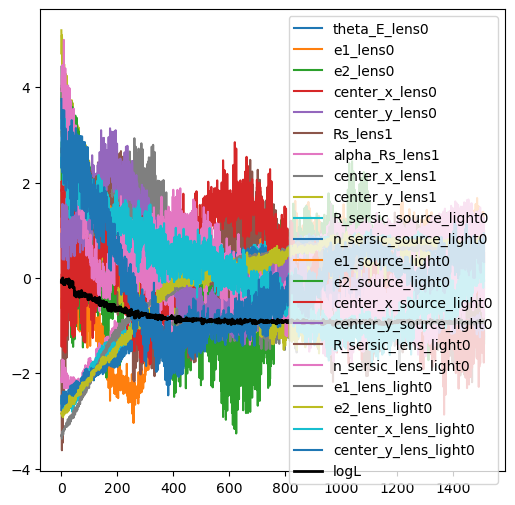

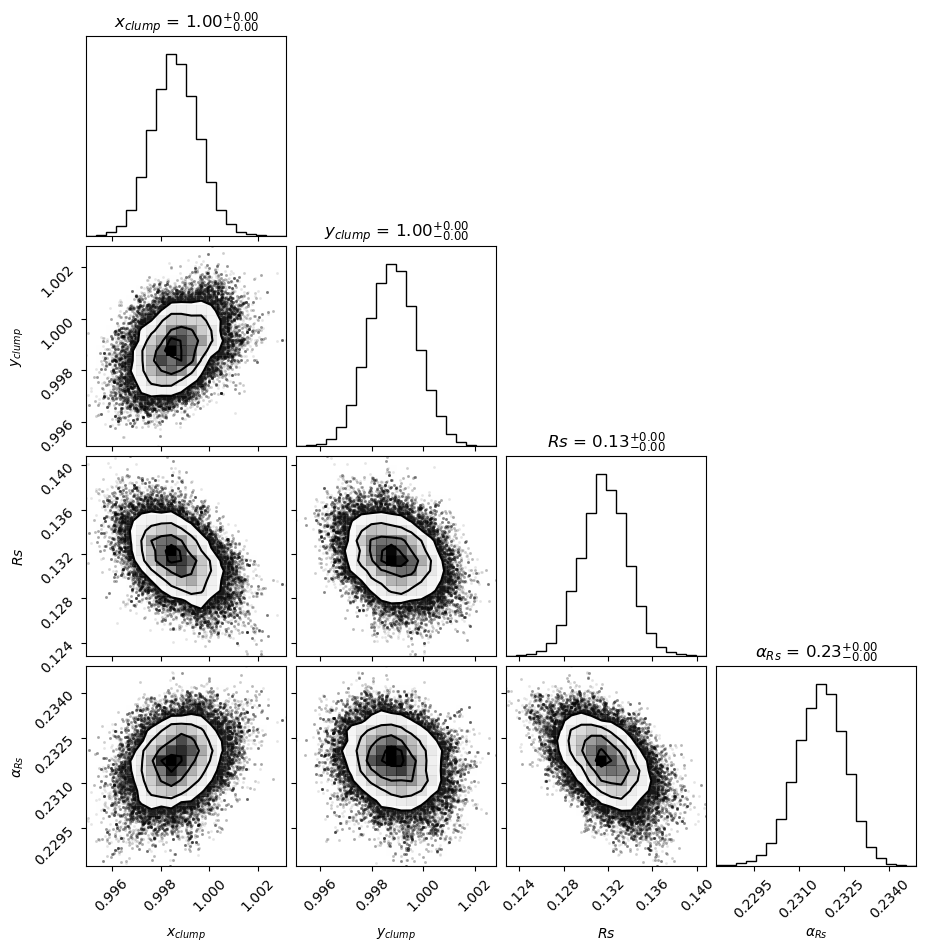

In [132]:
#######
## PLOTING FOR The clump
#######

from lenstronomy.Plots import chain_plot

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[0]


print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])


# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, fixed_lens, fixed_source, fixed_lens_light, kwargs_lens_init=kwargs_lens, **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()


mcmc_new_list = []
labels_new = [r"$x_{clump}$", r"$y_{clump}$", r"$Rs$", r"$\alpha_{Rs}$"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result = param.args2kwargs(samples_mcmc[i])
    mcmc_new_list.append([kwargs_result['kwargs_lens'][1]['center_x'], 
                          kwargs_result['kwargs_lens'][1]['center_y'], 
                          kwargs_result['kwargs_lens'][1]['Rs'], 
                          kwargs_result['kwargs_lens'][1]['alpha_Rs']])

fig = corner.corner(np.array(mcmc_new_list), labels=labels_new, show_titles=True)
fig.show()

plt.savefig("MCMC10*11_100.png")

In [7]:
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import Planck15 as cosmo

z_s = 1.5
z_l = 0.5

lens_cosmo = LensCosmo(z_lens=z_l, z_source=z_s, cosmo=cosmo)

_, _, c, _, M = lens_cosmo.nfw_angle2physical(0.1,0.02)

M, c

(19313455145.326694, array(74.88013068))

In [15]:
Rs, alpha_Rs = lens_cosmo.nfw_physical2angle(1e10, 50)

Rs, alpha_Rs

(0.12025687965809488, 0.03071262665901475)

In [ ]:
!python --version